# 03 — Adstock (carryover effects)

## Objective
Introduce carryover effects via adstock transformations and evaluate how
they change MMM estimates compared to the baseline model.

## Inputs
- Weekly dataset (`df_weekly`) built in `02_baseline_model.ipynb`
- Paid media spend columns (`spend_cols`)
- Target KPI (`target_col`)

## Output
- Adstock-transformed features
- Baseline vs Adstock model comparison (coefficients + fit metrics)


## Why adstock

### Context
Marketing effects often persist over time: spend in week t may affect purchases in weeks t+1, t+2, etc.

### Decision
Apply an adstock transformation to each paid media spend series before modeling.

### Rationale
Without carryover, MMM tends to undervalue upper-funnel channels and over-credit lower-funnel channels.
Adstock makes this delayed effect explicit and improves interpretability.


In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [6]:
target_col = "ALL_PURCHASES"
date_col = "DATE_DAY"

In [7]:

df_mmm = pd.read_csv("../data/processed/mmm_dataset_weekly.csv")
spend_cols = [c for c in df_mmm.columns if c.endswith("_SPEND")]



X_raw = df_mmm[spend_cols].copy()
y = df_mmm[target_col].copy()

X_raw.shape, y.shape


((251, 9), (251,))

## Adstock definition

We use **geometric adstock**, a simple carryover model:

adstock_t = x_t + theta * adstock_{t-1}

Where:
- x_t is spend at time t
- theta in [0,1) controls decay (higher theta = longer carryover)

This is a baseline implementation to build intuition.


In [8]:
def geometric_adstock(x: np.ndarray, theta: float) -> np.ndarray:
    """
    Geometric adstock transformation.
    x: 1D array (time series)
    theta: decay parameter in [0, 1)
    """
    x = np.asarray(x, dtype=float)
    out = np.zeros_like(x)
    for t in range(len(x)):
        out[t] = x[t] + (theta * out[t-1] if t > 0 else 0.0)
    return out


In [9]:
theta = 0.5  # initial decay guess

X_adstock = X_raw.apply(lambda s: geometric_adstock(s.values, theta), axis=0)
X_adstock = pd.DataFrame(X_adstock, columns=spend_cols, index=df_mmm.index)

X_adstock.head()


,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND
0,318.310000,142.830000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,819.855000,368.225000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1344.147500,467.312500,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1498.393750,558.566250,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1655.686875,600.703125,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Baseline model (raw spend)
m_base = LinearRegression().fit(X_raw, y)
pred_base = m_base.predict(X_raw)

# Adstock model
m_ads = LinearRegression().fit(X_adstock, y)
pred_ads = m_ads.predict(X_adstock)

metrics = pd.DataFrame({
    "model": ["baseline_raw", "adstock"],
    "r2": [r2_score(y, pred_base), r2_score(y, pred_ads)],
    "mae": [mean_absolute_error(y, pred_base), mean_absolute_error(y, pred_ads)],
})

metrics


,model,r2,mae
0,baseline_raw,0.656653,28.779574
1,adstock,0.674539,28.024382


In [11]:
coefs_base = pd.Series(m_base.coef_, index=spend_cols).sort_values(ascending=False)
coefs_ads = pd.Series(m_ads.coef_, index=spend_cols).sort_values(ascending=False)

pd.DataFrame({
    "coef_baseline": coefs_base,
    "coef_adstock": coefs_ads
}).sort_values("coef_adstock", ascending=False)


,coef_baseline,coef_adstock
GOOGLE_DISPLAY_SPEND,0.022894,0.039510
GOOGLE_PAID_SEARCH_SPEND,0.053828,0.032695
GOOGLE_SHOPPING_SPEND,0.056580,0.029394
GOOGLE_PMAX_SPEND,0.045969,0.024157
GOOGLE_VIDEO_SPEND,0.000000,0.000000
META_FACEBOOK_SPEND,0.000000,0.000000
META_INSTAGRAM_SPEND,0.000000,0.000000
META_OTHER_SPEND,0.000000,0.000000
TIKTOK_SPEND,0.000000,0.000000


## Interpretation

Comparing the baseline and adstock models reveals several important patterns:

- Search-related channels (Paid Search, Shopping, PMax) show **lower coefficients after adstock**.
  This suggests that part of their apparent impact in the baseline model was due to
  short-term effects being over-attributed.

- Display spend shows a **higher coefficient after adstock**, which is consistent with
  a channel that has longer carryover effects.

- Several channels (Meta, TikTok, Video) have coefficients equal to zero in both models.
  This may be due to:
  - High sparsity
  - Strong multicollinearity
  - Weak signal relative to noise
  - Effects being absorbed by other channels

Overall, adstock redistributes attribution across channels in a way that is more
consistent with typical funnel dynamics.


## Decision

Proceed with adstock as a core component of the MMM and explore sensitivity
to different carryover strengths (theta values).

## Rationale

Carryover effects materially change coefficient estimates and channel ranking.
Even without large in-sample fit improvements, adstock improves conceptual
validity and reduces short-term bias in attribution.


In [13]:
thetas = [0.1, 0.3, 0.5, 0.7, 0.9]

coef_by_theta = []

for theta in thetas:
    X_ads = X_raw.apply(lambda s: geometric_adstock(s.values, theta), axis=0)
    X_ads = pd.DataFrame(X_ads, columns=spend_cols, index=X_raw.index)

    model = LinearRegression().fit(X_ads, y)
    coefs = pd.Series(model.coef_, index=spend_cols)
    coefs["theta"] = theta
    coef_by_theta.append(coefs)

coef_df = pd.DataFrame(coef_by_theta)

coef_df


,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND,theta
0,0.050279,0.051397,0.041802,0.029118,0.0,0.0,0.0,0.0,0.0,0.1
1,0.042008,0.040611,0.033138,0.036817,0.0,0.0,0.0,0.0,0.0,0.3
2,0.032695,0.029394,0.024157,0.039510,0.0,0.0,0.0,0.0,0.0,0.5
3,0.022249,0.017719,0.014832,0.037707,0.0,0.0,0.0,0.0,0.0,0.7
4,0.008698,0.005455,0.004790,0.023710,0.0,0.0,0.0,0.0,0.0,0.9


In [14]:
coef_long = (
    coef_df
    .reset_index(drop=True)
    .melt(id_vars="theta", var_name="channel", value_name="coefficient")
)

coef_long = coef_long[coef_long["channel"] != "theta"]
coef_long.head()


,theta,channel,coefficient
0,0.1,GOOGLE_PAID_SEARCH_SPEND,0.050279
1,0.3,GOOGLE_PAID_SEARCH_SPEND,0.042008
2,0.5,GOOGLE_PAID_SEARCH_SPEND,0.032695
3,0.7,GOOGLE_PAID_SEARCH_SPEND,0.022249
4,0.9,GOOGLE_PAID_SEARCH_SPEND,0.008698


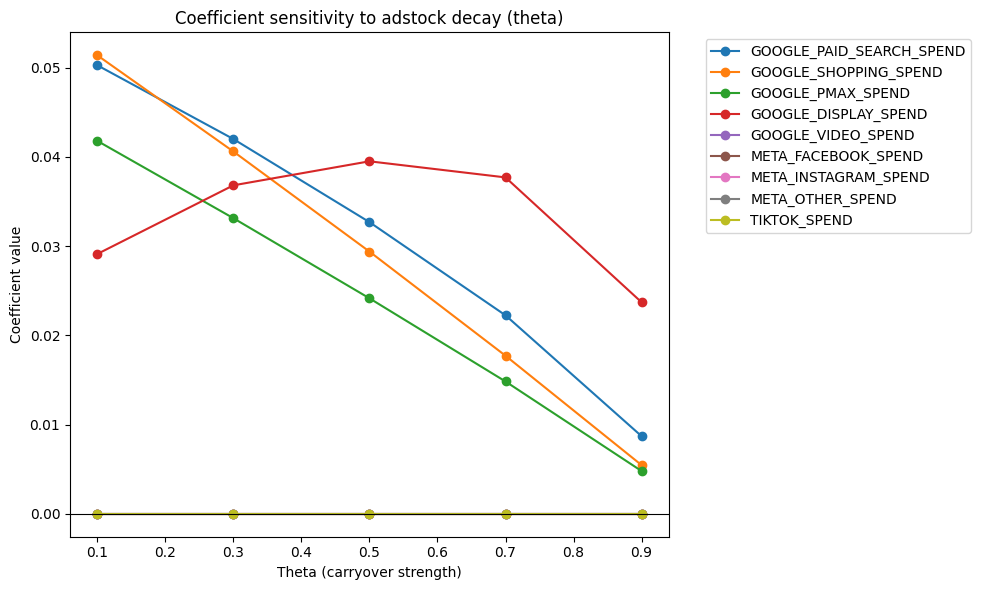

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for channel in coef_long["channel"].unique():
    subset = coef_long[coef_long["channel"] == channel]
    plt.plot(subset["theta"], subset["coefficient"], marker="o", label=channel)

plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Theta (carryover strength)")
plt.ylabel("Coefficient value")
plt.title("Coefficient sensitivity to adstock decay (theta)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Interpretation (theta sensitivity)

The sensitivity analysis reveals clear and interpretable patterns:

- Search-related channels show decreasing coefficients as carryover increases,
  consistent with predominantly short-term effects.

- Display shows an inverted-U pattern, suggesting meaningful carryover that is
  neither instantaneous nor extremely long-lived.

- Several channels remain at zero across all theta values, indicating limited
  identifiability given sparsity and multicollinearity.

Overall, the coefficient trajectories are smooth and stable, with no sign flips
or explosive behavior, suggesting reasonable model behavior.


## Decision

Use a moderate carryover strength as the baseline adstock assumption.

- Baseline theta: 0.5

## Rationale

- Theta = 0.5 balances short-term and medium-term effects.
- It aligns with plausible carryover for mixed funnel channels.
- Coefficients are stable and interpretable at this value.
- Extreme theta values (very low or very high) introduce stronger assumptions
  without clear empirical advantage.


Interpretación de θ:

θ ≈ 0.1 → impacto muy corto
θ ≈ 0.5 → impacto medio
θ ≈ 0.8 → impacto largo
θ > 0.9 → casi permanente (peligroso)

| Theta | Half-life (semanas) | Interpretación         |
| ----- | ------------------- | ---------------------- |
| 0.1   | ~0.3                | Impacto casi inmediato |
| 0.3   | ~0.6                | Muy corto plazo        |
| 0.5   | **1.0**             | Una semana             |
| 0.7   | ~1.9                | ~2 semanas             |
| 0.8   | ~3.1                | ~3 semanas             |
| 0.85  | ~4.3                | ~1 mes                 |
| 0.9   | ~6.6                | ~1.5 meses             |
| 0.95  | ~13.5               | ~3 meses               |


### Interpretation of theta

The adstock decay parameter (theta) can be interpreted in terms of half-life.

For example:
- theta ≈ 0.5 corresponds to a half-life of ~1 week
- theta ≈ 0.7 corresponds to a half-life of ~2 weeks

This interpretation helps ground modeling assumptions in business time scales.


## Adstock: mathematical formulation

### Baseline model (no carryover)

Let:
- $ x_{c,t} $ be the marketing spend of channel $ c $ at time $ t $
- $ y_t $ be the business KPI at time $ t $

The baseline linear MMM is:

$y_t = \beta_0 + \sum_{c=1}^{C} \beta_c \, x_{c,t} + \varepsilon_t$

This formulation assumes **instantaneous impact** and **no temporal memory**.

---

### Geometric adstock transformation

To model carryover effects, each spend series is transformed using geometric adstock:

$\tilde{x}_{c,t} = x_{c,t} + \theta_c \cdot \tilde{x}_{c,t-1}$

where:
- $ \tilde{x}_{c,t} $ is the adstocked spend
- $ \theta_c \in [0,1) $ is the decay parameter
- $ \tilde{x}_{c,0} = x_{c,0} $

This is a recursive difference equation.

---

### Expanded form (intuition)

By recursion:

$\tilde{x}_{c,t}
= x_{c,t}
+ \theta_c x_{c,t-1}
+ \theta_c^2 x_{c,t-2}
+ \theta_c^3 x_{c,t-3}
+ \dots$

Past spend continues to contribute to the current period with exponentially
decaying weights.

---

### MMM with adstock

Replacing raw spend with adstocked spend:

$y_t = \beta_0 + \sum_{c=1}^{C} \beta_c \, \tilde{x}_{c,t} + \varepsilon_t$

In this formulation:
- $ \beta_c $ measures the marginal impact of accumulated marketing pressure
- not only of instantaneous spend

---

### Temporal interpretation of $ \theta $

The contribution of spend after $ k $ periods is:

$w_k = \theta^k$

The **half-life** $ h $ (time until the effect halves) satisfies:

$\theta^{h} = \frac{1}{2}$

Solving for $ h $:

$h = \frac{\ln(2)}{-\ln(\theta)}$

This allows interpreting $ \theta $ in business time units (e.g. weeks).

---

### Example values

| $ \theta $ | Half-life (periods) |
|--------------|---------------------|
| 0.5 | $ \approx 1 $ |
| 0.7 | $ \approx 1.9 $ |
| 0.8 | $ \approx 3.1 $ |
| 0.9 | $ \approx 6.6 $ |

---

### Model assumptions

The geometric adstock formulation assumes:
1. Exponential decay of marketing effects
2. Constant decay rate over time
3. Proportional carryover of past impact
4. No diminishing returns (handled separately via saturation)

If $ \theta = 0 $, the model reduces to the baseline MMM without carryover.


## Adstock: formulación matemática

### Modelo base (sin carryover)

Sea:
- $ x_{c,t} $ el gasto publicitario del canal $ c $ en el periodo $ t $
- $ y_t $ el KPI de negocio en el periodo $ t $

El MMM lineal base es:

$y_t = \beta_0 + \sum_{c=1}^{C} \beta_c \, x_{c,t} + \varepsilon_t$

Esta formulación asume **impacto instantáneo** y **ausencia de memoria temporal**.

---

### Transformación de adstock geométrico

Para modelar persistencia temporal, cada serie de gasto se transforma mediante adstock geométrico:

$\tilde{x}_{c,t} = x_{c,t} + \theta_c \cdot \tilde{x}_{c,t-1}$

donde:
- $ \tilde{x}_{c,t} $ es el gasto adstockeado
- $ \theta_c \in [0,1) $ es el parámetro de decaimiento
- $ \tilde{x}_{c,0} = x_{c,0} $

Se trata de una ecuación recursiva en diferencias.

---

### Forma expandida (intuición)

Desarrollando la recurrencia:

$\tilde{x}_{c,t}
= x_{c,t}
+ \theta_c x_{c,t-1}
+ \theta_c^2 x_{c,t-2}
+ \theta_c^3 x_{c,t-3}
+ \dots$

El gasto pasado sigue contribuyendo al periodo actual con pesos que decrecen
exponencialmente.

---

### MMM con adstock

Sustituyendo el gasto original por el gasto adstockeado:

$y_t = \beta_0 + \sum_{c=1}^{C} \beta_c \, \tilde{x}_{c,t} + \varepsilon_t$

En esta formulación:
- $ \beta_c $ mide el impacto marginal del **stock acumulado** de marketing
- no solo del gasto instantáneo

---

### Interpretación temporal de $ \theta $

La contribución del gasto tras $ k $ periodos es:

$w_k = \theta^k$

La **vida media** (half-life) $ h $ satisface:

$\theta^{h} = \frac{1}{2}$

Resolviendo:

$h = \frac{\ln(2)}{-\ln(\theta)}$

Esto permite interpretar $ \theta $ en unidades temporales de negocio (semanas).

---

### Valores de ejemplo

| $ \theta $ | Vida media (periodos) |
|-------------|-----------------------|
| 0.5 | $ \approx 1 $ |
| 0.7 | $ \approx 1.9 $ |
| 0.8 | $ \approx 3.1 $ |
| 0.9 | $ \approx 6.6 $ |

---

### Supuestos del modelo

El adstock geométrico asume:
1. Decaimiento exponencial del efecto
2. Tasa de decaimiento constante en el tiempo
3. Proporcionalidad del carryover
4. Ausencia de saturación (tratada posteriormente)

Si $ \theta = 0 $, el modelo se reduce al MMM base sin carryover.
